Ion simulation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from PyonDetect.ion.ion import Ion, BerylliumIon, CalciumIon
from PyonDetect.estimator.estimator import EntropyGainEstimator, MinExpectedBinsEstimator, ThresholdingEstimator, AdaptiveMLEstimator, NonPoissonianAdaptiveMLEstimator
from PyonDetect.environment.environment import SimulationEnvironment

In [ ]:
# initialize simulation environment
R_D = 0.1 / 200 # per us
R_B = 25 / 200 #per us
initial_state = 0 # bright
n_subbins = 25
t_detection = 200 # us

ion = Ion(initial_state, R_dark=R_D, R_bright=R_B)
estimator = EntropyGainEstimator(R_D=R_D, R_B=R_B, e_c=1e-4, n_subbins_max=n_subbins, n_counts_max=10, save_trajectory=True)
env = SimulationEnvironment([ion], [estimator], detection_time=t_detection, n_subbins=n_subbins, n_repetition=10000)

In [ ]:
# let simulation run
env.run()

In [ ]:
# save data to files
env.save_to_csv()
env.save_to_json()

In [ ]:
# Opening trajectory JSON file
f = open('n_subbins=25.json')
binned_traj = json.loads(json.load(f))

n_pi_per_subbin = np.zeros(25)
p_b_avg_per_subbin = np.zeros(25)
n_est_left_per_subbin = np.zeros(25)

n_repetition = 10000
subbin_idx = np.arange(1, 26, 1)

for traj_i in binned_traj.keys():
    # get sub dict
    subdict = binned_traj[traj_i]
    p = subdict['probability']
    pi_pulse_traj = subdict['pi_pulse_0']
    p_b_traj = subdict['p_b_0']
    for i in range(len(p_b_traj)):
        n_pi_per_subbin[i] += p * n_repetition * pi_pulse_traj[i]
        n_est_left_per_subbin[i] += p * n_repetition
        p_b_avg_per_subbin[i] += p * n_repetition * p_b_traj[i]

idx_not_zero = np.argwhere(n_est_left_per_subbin != 0)
n_est_left_per_subbin = n_est_left_per_subbin[idx_not_zero]
p_b_avg_per_subbin = p_b_avg_per_subbin[idx_not_zero] / n_est_left_per_subbin
subbin_idx = subbin_idx[idx_not_zero]
p_pi_per_subbin = n_pi_per_subbin[idx_not_zero] / n_est_left_per_subbin
print(len(subbin_idx))

In [ ]:
fig, axs = plt.subplots(2, 1, sharex='col')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
size = 2

fig.suptitle('Trajectory Analysis Entropy Gain Estimator (n = 10000)')

axs[0].set_title('Probability of $\pi$-pulse application')
ln1 = axs[0].plot(subbin_idx, p_pi_per_subbin, color='tab:blue', label = 'Probability $\pi$-pulse', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0].set_ylabel('P[$\pi$-pulse during subbin]')
ax01 = axs[0].twinx()
ln2 = ax01.semilogy(subbin_idx, n_est_left_per_subbin, color='tab:orange', label = '# estimators left', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
ax01.set_ylabel('# estimators left')
axs[0].set_yticks(np.arange(0, 1.2, 0.2))
axs[0].grid('all')
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs, loc='upper right', bbox_to_anchor=(1.4, 1.0))



axs[1].set_title('Average normalized bright state probability')
ln1 = axs[1].plot(subbin_idx, p_b_avg_per_subbin,  label = 'Average $p_B$', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1].set_ylabel('Average $p_B$')
ax11 = axs[1].twinx() 
ln2 = ax11.semilogy(subbin_idx, n_est_left_per_subbin, color='tab:orange', label = '# estimators left', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
ax11.set_ylabel('# estimators left')
axs[0].set_yticks(np.arange(0, 1.2, 0.2))
axs[0].grid('all')
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs, loc='upper right', bbox_to_anchor=(1.4, 1.0))
axs[1].set_yticks(np.arange(0, 1.1, 0.2))
axs[1].set_xticks(np.arange(1, 26, 1))
axs[1].set_xlabel('subbin index')
axs[1].grid('all')

fig.savefig("entropy_gain_traj_analysis.pdf", bbox_inches='tight')



In [ ]:
## some fun
e_c = 1e-4
ln_beta_ec = np.log((1 - e_c) / e_c)
R_B = 10 / 200 # per us
R_D = 1 / 200 # per us
delta_R = R_B - R_D

t_bin = 4
def alpha(R_B, t_bin):
    a = np.exp(-R_B * t_bin)
    coeff_alpha = 1 / (1 - a)
    return coeff_alpha

p_b = np.linspace(0.001, 0.999, 1000)
def decision(p_b, R_B, t_bin):
    return (1 - 2 * p_b) * (alpha(R_B, t_bin) - np.ceil((ln_beta_ec - np.log(p_b / (1-p_b))) / (delta_R * t_bin)))
plt.plot(p_b, decision(p_b, R_B, t_bin))
threshold_idx = np.argwhere(decision(p_b, R_B, t_bin) < 0)

In [ ]:
t_detection = 200
n_bins = np.arange(5, 30)
print(n_bins)
t_bin = t_detection / n_bins
print(t_bin)
plt.scatter(200/t_bin, t_bin * alpha(R_B, t_bin))
print(200/t_bin, t_bin * alpha(R_B, t_bin))

In [ ]:
# run test

def run_environment(n_bins, initial_state):
    R_D = 0 / 200 # per us
    R_B = 25 / 200 # per us
    e_c = 1e-4
    t_detection = 200
    ions = [Ion(initial_state, R_dark=R_D, R_bright=R_B) for i in range(3)]
    estimator1 = MinExpectedBinsEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, save_trajectory=False)
    estimator2 = AdaptiveMLEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, save_trajectory=False)
    estimator3 = EntropyGainEstimator(R_D=R_D, R_B=R_B, e_c=e_c, n_subbins_max=n_bins, n_counts_max=10, save_trajectory=False)
    estimators = [estimator1, estimator2, estimator3]
    env = SimulationEnvironment(ions, estimators, detection_time=t_detection, n_subbins=n_bins, n_repetition=100)
    env.run()
    env.save_to_csv()

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
idx = np.arange(5, 36)
print(len(idx))
paths = ['./detection_sim/outputs/dark_R_D_0/',
         './detection_sim/outputs/bright_R_D_0/',
         './detection_sim/outputs/dark_R_D_0_1/',
         './detection_sim/outputs/bright_R_D_0_1/',
         './detection_sim/outputs/dark_R_D_0_5/',
         './detection_sim/outputs/bright_R_D_0_5/']

In [ ]:
def load_data(path, idx):
    filename = 'n_subbins='+str(int(idx))+'.csv'
    df = pd.read_csv(path + filename)
    return df

In [ ]:
n_subbins_avg_dark_R_D_0 = np.zeros((len(idx), 3))
t_detection_avg_dark_R_D_0 = np.zeros((len(idx), 3))
n_errors_dark_R_D_0 = np.zeros((len(idx), 3))
n_pi_pulse_avg_dark_R_D_0 = np.zeros((len(idx), 3))

n_subbins_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))
t_detection_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))
n_errors_dark_R_D_0_1 = np.zeros((len(idx), 3))
n_pi_pulse_avg_dark_R_D_0_1 = np.zeros((len(idx), 3))

n_subbins_avg_dark_R_D_0_5 = np.zeros((len(idx), 3))
t_detection_avg_dark_R_D_0_5 = np.zeros((len(idx), 3))
n_errors_dark_R_D_0_5 = np.zeros((len(idx), 3))
n_pi_pulse_avg_dark_R_D_0_5 = np.zeros((len(idx), 3))

n_subbins_avg_bright_R_D_0 = np.zeros((len(idx), 3))
t_detection_avg_bright_R_D_0 = np.zeros((len(idx), 3))
n_errors_bright_R_D_0 = np.zeros((len(idx), 3))
n_pi_pulse_avg_bright_R_D_0 = np.zeros((len(idx), 3))

n_subbins_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))
t_detection_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))
n_errors_bright_R_D_0_1 = np.zeros((len(idx), 3))
n_pi_pulse_avg_bright_R_D_0_1 = np.zeros((len(idx), 3))

n_subbins_avg_bright_R_D_0_5 = np.zeros((len(idx), 3))
t_detection_avg_bright_R_D_0_5 = np.zeros((len(idx), 3))
n_errors_bright_R_D_0_5 = np.zeros((len(idx), 3))
n_pi_pulse_avg_bright_R_D_0_5 = np.zeros((len(idx), 3))

In [ ]:
for j, i in enumerate(idx):
    df = load_data(paths[0], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = len(df['prediction_' + str(l)].to_numpy()) - np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_dark_R_D_0[j, l] = n_subbins_avg
        t_detection_avg_dark_R_D_0[j, l] = t_detection_avg
        n_errors_dark_R_D_0[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_dark_R_D_0[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[1], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_bright_R_D_0[j, l] = n_subbins_avg
        t_detection_avg_bright_R_D_0[j, l] = t_detection_avg
        n_errors_bright_R_D_0[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_bright_R_D_0[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[2], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = len(df['prediction_' + str(l)].to_numpy()) - np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_dark_R_D_0_1[j, l] = n_subbins_avg
        t_detection_avg_dark_R_D_0_1[j, l] = t_detection_avg
        n_errors_dark_R_D_0_1[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_dark_R_D_0_1[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[3], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_bright_R_D_0_1[j, l] = n_subbins_avg
        t_detection_avg_bright_R_D_0_1[j, l] = t_detection_avg
        n_errors_bright_R_D_0_1[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_bright_R_D_0_1[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
            
    df = load_data(paths[4], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = len(df['prediction_' + str(l)].to_numpy()) - np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_dark_R_D_0_5[j, l] = n_subbins_avg
        t_detection_avg_dark_R_D_0_5[j, l] = t_detection_avg
        n_errors_dark_R_D_0_5[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_dark_R_D_0_5[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())
        
    df = load_data(paths[5], i)
    for l in range(3):
        n_subbins_avg = np.mean(df['n_subbins_' + str(l)].to_numpy())
        t_detection_avg = (200 / i) * n_subbins_avg
        n_errors = np.sum(df['prediction_' + str(l)].to_numpy())
        n_subbins_avg_bright_R_D_0_5[j, l] = n_subbins_avg
        t_detection_avg_bright_R_D_0_5[j, l] = t_detection_avg
        n_errors_bright_R_D_0_5[j, l] = n_errors
        if l != 1:
            n_pi_pulse_avg_bright_R_D_0_5[j, l] = np.mean(df['n_pi_pulses_' + str(l)].to_numpy())

In [ ]:
# plotting fun detection time

fig, axs = plt.subplots(2, 3, sharex='all', sharey='row')
fig.set_size_inches(9, 4.5)
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
size = 2
fig.suptitle('Average detection times comparison ($e_c = 10^{-4}$)')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 0], label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, t_detection_avg_dark_R_D_0[:, 2], label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('Detection time $[\mu s$]')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('all')

# plot top middle (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 0], label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, t_detection_avg_dark_R_D_0_1[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].grid('all')

# plot top right (dark detection R_D = 0.1)
axs[0, 2].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 2].plot(idx, t_detection_avg_dark_R_D_0_5[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[0, 2].plot(idx, t_detection_avg_dark_R_D_0_5[:, 0], label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 2].plot(idx, t_detection_avg_dark_R_D_0_5[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 2].grid('all')

# plot bottom left (dark detection R_D = 0.1)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 0], label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, t_detection_avg_bright_R_D_0[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('Detection time $[\mu s$]')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(0.55, -0.5))

# plot bottom middle (dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 0], label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, t_detection_avg_bright_R_D_0_1[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].grid('all')


# plot bottom right (dark detection R_D = 0.1)
axs[1, 2].set_title('Bright state detection ($R_D = 0.5$)')
axs[1, 2].plot(idx, t_detection_avg_bright_R_D_0_5[:, 1], label='AML', linewidth = linewidth, linestyle='--', marker = 'v', markersize=size, mew=linewidth)
axs[1, 2].plot(idx, t_detection_avg_bright_R_D_0_5[:, 0], label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 2].plot(idx, t_detection_avg_bright_R_D_0_5[:, 2], label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 2].set_xlabel('# of subbins')
axs[1, 2].set_yticks(np.arange(0, 70, 10))
axs[1, 2].grid('all')

fig.savefig("avg_t_det.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2, 3, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
fig.set_size_inches(9, 4.5)
linewidth = 0.6
size = 2
fig.suptitle('Average number of $\pi$-pulse comparison ($e_c = 10^{-4}$)')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(idx, n_pi_pulse_avg_dark_R_D_0[:, 0], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(idx, n_pi_pulse_avg_dark_R_D_0[:, 2], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('# $\pi$-pulse')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('all')

# plot top middle (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(idx, n_pi_pulse_avg_dark_R_D_0_1[:, 0], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(idx, n_pi_pulse_avg_dark_R_D_0_1[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].grid('all')

# plot top right (dark detection R_D = 0.5)
axs[0, 2].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 2].plot(idx, n_pi_pulse_avg_dark_R_D_0_5[:, 0], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 2].plot(idx, n_pi_pulse_avg_dark_R_D_0_5[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 2].set_yticks(np.arange(1, 3, 0.5))
axs[0, 2].grid('all')

# plot bottom left (dark detection R_D = 0.0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(idx, n_pi_pulse_avg_bright_R_D_0[:, 0], color='tab:orange', label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(idx, n_pi_pulse_avg_bright_R_D_0[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('# $\pi$-pulse')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(1, -0.5))

# plot bottom middle (dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(idx, n_pi_pulse_avg_bright_R_D_0_1[:, 0], color='tab:orange', label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(idx, n_pi_pulse_avg_bright_R_D_0_1[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].grid('all')

# plot bottom right(dark detection R_D = 0.5)
axs[1, 2].set_title('Bright state detection ($R_D = 0.5$)')
axs[1, 2].plot(idx, n_pi_pulse_avg_bright_R_D_0_5[:, 0], color='tab:orange', label='MinBins',linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 2].plot(idx, n_pi_pulse_avg_bright_R_D_0_5[:, 2], color='tab:green', label='Entropy gain', linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 2].set_xlabel('# of subbins')
axs[1, 2].set_yticks(np.arange(0, 7, 1))
axs[1, 2].grid('all')

fig.savefig("avg_n_Pi.pdf", bbox_inches='tight')

In [ ]:
# plotting fun errors

fig, axs = plt.subplots(2, 3, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
fig.set_size_inches(9, 4.5)
linewidth = 0.8
size = 4
fig.suptitle('Number of errors (n = 10000, $e_c = 10^{-4})$')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].scatter(idx - 0.25, n_errors_dark_R_D_0[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[0, 0].scatter(idx, n_errors_dark_R_D_0[:, 0], label='MinBins', linewidths = linewidth, marker = '+', s=size)
axs[0, 0].scatter(idx + 0.25, n_errors_dark_R_D_0[:, 2], label='Entropy gain',linewidths = linewidth, marker = 'o',s=size)
axs[0, 0].set_ylabel('# errors')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].grid('row')
axs[0, 0].set_axisbelow(True)


# plot top middle (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].scatter(idx - 0.25, n_errors_dark_R_D_0_1[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[0, 1].scatter(idx, n_errors_dark_R_D_0_1[:, 0], label='MinBins', linewidths = linewidth, marker = '+', s=size)
axs[0, 1].scatter(idx + 0.25, n_errors_dark_R_D_0_1[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[0, 1].grid('row')
axs[0, 1].set_axisbelow(True)

# plot top right (dark detection R_D = 0.5)
axs[0, 2].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 2].scatter(idx - 0.25, n_errors_dark_R_D_0_5[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[0, 2].scatter(idx, n_errors_dark_R_D_0_5[:, 0], label='MinBins', linewidths = linewidth, marker = '+', s=size)
axs[0, 2].scatter(idx + 0.25, n_errors_dark_R_D_0_5[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[0, 2].set_yticks(np.arange(0, 3, 1))
axs[0, 2].grid('row')
axs[0, 2].set_axisbelow(True)

# plot bottom left (dark detection R_D = 0.0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].scatter(idx - 0.25, n_errors_bright_R_D_0[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[1, 0].scatter(idx, n_errors_bright_R_D_0[:, 0], label='MinBins',linewidths = linewidth, marker = '+', s=size)
axs[1, 0].scatter(idx + 0.25, n_errors_bright_R_D_0[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[1, 0].set_xlabel('# of subbins')
axs[1, 0].set_ylabel('# errors')
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid('row')
axs[1, 0].legend(loc='lower left', ncol=3, columnspacing=12, bbox_to_anchor=(0.55, -0.5))

# plot bottom middle (dark detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].scatter(idx - 0.25, n_errors_bright_R_D_0_1[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[1, 1].scatter(idx, n_errors_bright_R_D_0_1[:, 0], label='MinBins',linewidths = linewidth, marker = '+', s=size)
axs[1, 1].scatter(idx + 0.25, n_errors_bright_R_D_0_1[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[1, 1].set_xlabel('# of subbins')
axs[1, 1].set_axisbelow(True)
axs[1, 1].grid('row')

# plot bottom right(dark detection R_D = 0.5)
axs[1, 2].set_title('Bright state detection ($R_D = 0.5$)')
axs[1, 2].scatter(idx - 0.25, n_errors_bright_R_D_0_5[:, 1], label='AML', linewidths = linewidth, marker = 'v', s=size)
axs[1, 2].scatter(idx, n_errors_bright_R_D_0_5[:, 0], label='MinBins',linewidths = linewidth, marker = '+', s=size)
axs[1, 2].scatter(idx + 0.25, n_errors_bright_R_D_0_5[:, 2], label='Entropy gain', linewidths = linewidth, marker = 'o', s=size)
axs[1, 2].set_xlabel('# of subbins')
axs[1, 2].set_yticks(np.arange(0, 5, 1))
axs[1, 2].set_axisbelow(True)
axs[1, 2].grid('row')

fig.savefig("errors.pdf", bbox_inches='tight')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, entropy
from scipy import optimize

def entropy_diff_n(mu_D, mu_B, p_b, n):
    p_i_dark = poisson.pmf(n, mu_D)
    p_i_bright = poisson.pmf(n, mu_B)

    # no Pi
    p_D_no_Pi = (1 - p_b) * p_i_dark
    p_B_no_Pi = p_b * p_i_bright

    # pi
    p_D_Pi = (1 - p_b) * p_i_bright
    p_B_Pi = p_b * p_i_dark

    # return weighted difference
    return (p_i_dark + p_i_bright) * (entropy([p_D_Pi, p_B_Pi], base = 2) - entropy([p_D_no_Pi, p_B_no_Pi], base = 2))

def entropy_diff(p_b, mu_D, mu_B, n_max):
    H_diff = 0
    for i in range(n_max):
        # add
        H_diff_n_weighted = entropy_diff_n(mu_D, mu_B, p_b, i)
        H_diff+= H_diff_n_weighted
        
    return H_diff



In [ ]:
n_bins = 35
t_bin = 200 / n_bins
R_D = 0.5 / 200
R_B =  25 / 200

mu_D = t_bin * R_D
mu_B = t_bin * (R_D + R_B)

n_max = 10
p_b = np.linspace(0, 1, 1000)

fig, axs = plt.subplots(2, 1, sharex='all')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
linewidth = 0.6
dx = 0.03
fig.suptitle(f'Entropy difference ($\lambda_D =$ {mu_D:.4f}, $\lambda_B =$ {mu_B:.4f})')

axs[0].set_title('Entropy difference for n counts')
H_diff_tot = np.zeros(len(p_b))
for i in range(n_max):
    H_diff_i = [entropy_diff_n(mu_D, mu_B, p, float(i)) for p in p_b]
    H_diff_tot += np.array(H_diff_i)
    axs[0].plot(p_b, H_diff_i, label='n = ' + str(i), linewidth=linewidth, linestyle = '--')
axs[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
axs[0].grid('all')
axs[0].set_ylabel('$\Delta H_{n}$ [bits]')

axs[1].set_title('Total difference term')
# find zeros and plot
sol_low = optimize.bisect(entropy_diff, a=1e-5, b=0.1, args=(mu_D, mu_B, n_max))
sol_high = optimize.bisect(entropy_diff, a=0.9, b=1 - 1e-9, args=(mu_D, mu_B, n_max))
axs[1].scatter((0, sol_low, 0.5, sol_high, 1), np.zeros(5), color='r', marker='+', s=10, linewidths=0.5)
axs[1].text(sol_low + dx,0,f'$p_B$ = {sol_low:.3f}',ha='left', va='center')
axs[1].text(sol_high - dx,0,f'$p_B$ = {sol_high:.3f}',ha='right', va='center')

axs[1].plot(p_b, H_diff_tot, label='$\Delta H_{tot}$' + str(i), linewidth=linewidth, linestyle = '--')
axs[1].set_xlabel('$p_{bright}$')
axs[1].set_xticks(np.arange(0, 1.1, 0.1))
axs[1].set_ylabel('$\Delta H_{tot}$ [bits]')
axs[1].grid('all')
axs[1].set_axisbelow(True)

fig.savefig("terms_entropy_difference.pdf", bbox_inches='tight')

In [ ]:
from scipy.stats import poisson
R_D = 0.1 / 200
R_B = 25 / 200


p_D = np.linspace(e_c, 0.1, 100)

t_detect = 200
n_bins = np.arange(5, 36, 1)
t_bin = t_detect / n_bins


def probability_terminate(p_D, t_bin, e_c = 1e-4, R_B=25.0/200, R_D=0.1/200):
    beta_ec = np.log((1 - e_c) / e_c)
    beta_R = np.log(1 + (R_B / R_D))
    beta_pD = np.log(p_D / (1 - p_D))
    
    n_min = np.ceil((beta_ec + beta_pD + R_B * t_bin) / beta_R)
    p_terminate = 1 - poisson.cdf(n_min-1, mu = (R_B + R_D) * t_bin)
    return p_terminate

def t_det_avg(n_bins, t_detection=200, e_c = 1e-4, R_B=25.0/200, R_D=0.1/200, n_max=10):
    t_bin = t_detection / n_bins
    gamma_D = 0
    for i in range(n_max):
        gamma_D += poisson.pmf(i, t_bin * R_D) * poisson.pmf(i, t_bin * (R_D + R_B))
    gamma_B = 0
    for i in range(n_max):
        gamma_B += poisson.pmf(i, t_bin * (R_D + R_B))**2
        
    p_D_k = 0.5
    p_B_k = 0.5
    p_getting_to_k = 1
    k_avg = 0
    for k in range(n_bins - 1):
        p_D_k_unnorm = p_D_k * gamma_D
        p_B_k_unnorm = p_B_k * gamma_B
        s = p_D_k_unnorm + p_B_k_unnorm
        p_D_k = p_D_k_unnorm / s
        p_B_k = p_B_k_unnorm / s
        
        p_term = probability_terminate(p_D_k, t_bin, R_B=R_B, R_D=R_D)
        k_avg += (k + 1) * p_getting_to_k * p_term
        p_getting_to_k *= (1 - p_term)
    
    k_avg += n_bins * p_getting_to_k
    
    t_det = k_avg * t_bin
    return t_det

In [ ]:
n_bins = np.arange(5, 35, 1)
t_avg = [t_det_avg(n) for n in n_bins]
plt.scatter(n_bins, t_avg)

In [ ]:
paths = [
    'detection_sim/outputs/pi_success_R_D_0/EG/',
    'detection_sim/outputs/pi_success_R_D_0_1/EG/',
    'detection_sim/outputs/pi_success_R_D_0/MB/',
    'detection_sim/outputs/pi_success_R_D_0_1/MB/'
]
subfolders = ["bright_success_test/", "dark_success_test/"]
p_success = np.arange(0.995, 1, 0.0005)
filenames = [f'n_subbins=20_p_pi_suc={p:.5f}.csv' for p in p_success]

infidelity_MB = np.zeros((4, len(p_success)))
infidelity_EG = np.zeros((4, len(p_success)))
avg_pi_pulse_MB = np.zeros((4, len(p_success)))
avg_pi_pulse_EG = np.zeros((4, len(p_success)))
avg_t_det_MB = np.zeros((4, len(p_success)))
avg_t_det_EG = np.zeros((4, len(p_success)))
t_detection = 200
n_bins = 20
t_bin = t_detection / n_bins

for i, path in enumerate(paths):
    for j, subfolder in enumerate(subfolders):
        for k, filename in enumerate(filenames):
            file = './' + path + subfolder + filename
            # load data set
            df = pd.read_csv(file)
            infidelity_i = np.mean(df['prediction_0'].to_numpy())
            if j == 1:
                infidelity_i = 1 - infidelity_i
            n_subbins = np.mean(df['n_subbins_0'].to_numpy())
            t_det_avg_i = t_bin * n_subbins
            n_pi_avg_i = np.mean(df['n_pi_pulses_0'].to_numpy())
            if i in (0, 1): # EG
                idx = 2 * i + j
                infidelity_EG[idx, k] = infidelity_i
                avg_pi_pulse_EG[idx, k] = n_pi_avg_i
                avg_t_det_EG[idx, k] = t_det_avg_i
            else: # MB
                idx = 2 * (i-2) + j
                infidelity_MB[idx, k] = infidelity_i
                avg_pi_pulse_MB[idx, k] = n_pi_avg_i
                avg_t_det_MB[idx, k] = t_det_avg_i
        

In [ ]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
fig.set_size_inches(9, 4.5)
linewidth = 0.6
size = 2
p_fail = np.linspace(0.0, 0.005, 11)
fig.suptitle('Detection error for $\pi$-pulse infidelity ($n_{subbins}$ = 20, n = 100000)')
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(1-p_success, infidelity_MB[1, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(1-p_success, infidelity_EG[1, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
# prediction for error rate
MB_prediction = 1 - (1-p_fail)**avg_pi_pulse_MB
axs[0, 0].set_ylabel('Detection error rate')
axs[0, 0].grid('all')


# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(1-p_success, infidelity_MB[3, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(1-p_success, infidelity_EG[3, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].set_yticks(np.arange(0.0, 0.009, 0.001))
axs[0, 1].grid('all')

# plot bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(1-p_success, infidelity_MB[0, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(1-p_success, infidelity_EG[0, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_ylabel('Detection error rate')
axs[1, 0].set_xticks(np.arange(0.0, 0.005, 0.001))
axs[1, 0].set_xlabel('$\pi$-pulse infidelity')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=2, columnspacing=12, bbox_to_anchor=(0.65, -0.5))


# plot top right (Bright detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(1-p_success, infidelity_MB[2, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(1-p_success, infidelity_EG[2, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('$\pi$-pulse infidelity')
axs[1, 1].set_xticks(np.arange(0.0, 0.006, 0.001))
axs[1, 1].set_yticks(np.arange(0.0, 0.009, 0.001))
axs[1, 1].grid('all')

fig.savefig("det_err_p_pi.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
fig.set_size_inches(9, 4.5)
linewidth = 0.6
size = 2
fig.suptitle('Average detection time for $\pi$-pulse infidelity ($n_{subbins}$ = 20, n = 100000)')

# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(1-p_success, avg_t_det_MB[1, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(1-p_success, avg_t_det_EG[1, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('Average detection time [$\mu s$]')
axs[0, 0].grid('all')


# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(1-p_success, avg_t_det_MB[3, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(1-p_success, avg_t_det_EG[3, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].set_yticks(np.arange(20.0, 45.0, 5.0))
axs[0, 1].grid('all')

# plot bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(1-p_success, avg_t_det_MB[0, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(1-p_success, avg_t_det_EG[0, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_ylabel('Average detection time [$\mu s$]')
axs[1, 0].set_xticks(np.arange(0.0, 0.005, 0.001))
axs[1, 0].set_xlabel('$\pi$-pulse infidelity')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=2, columnspacing=12, bbox_to_anchor=(0.65, -0.5))


# plot top right (Bright detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(1-p_success, avg_t_det_MB[2, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(1-p_success, avg_t_det_EG[2, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('$\pi$-pulse infidelity')
axs[1, 1].set_xticks(np.arange(0.0, 0.006, 0.001))
axs[1, 1].set_yticks(np.arange(20.0, 45.0, 5.0))
axs[1, 1].grid('all')

fig.savefig("t_det_p_pi.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
plt.rc('font', size=7)  
plt.rc('axes', titlesize=6)
fig.set_size_inches(9, 4.5)
linewidth = 0.6
size = 2
fig.suptitle('Average number of $\pi$-pulse for $\pi$-pulse infidelity ($n_{subbins}$ = 20, n = 100000)')

# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].plot(1-p_success, avg_pi_pulse_MB[1, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 0].plot(1-p_success, avg_pi_pulse_EG[1, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 0].set_ylabel('# $\pi$-pulses')
axs[0, 0].grid('all')


# plot top right (dark detection R_D = 0.1)
axs[0, 1].set_title('Dark state detection ($R_D = 0.1$)')
axs[0, 1].plot(1-p_success, avg_pi_pulse_MB[3, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[0, 1].plot(1-p_success, avg_pi_pulse_EG[3, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[0, 1].set_yticks(np.arange(0, 2, 0.25))
axs[0, 1].grid('all')

# plot bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].plot(1-p_success, avg_pi_pulse_MB[0, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 0].plot(1-p_success, avg_pi_pulse_EG[0, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 0].set_ylabel('# $\pi$-pulses')
axs[1, 0].set_xticks(np.arange(0.0, 0.005, 0.001))
axs[1, 0].set_xlabel('$\pi$-pulse infidelity')
axs[1, 0].grid('all')
axs[1, 0].legend(loc='lower left', ncol=2, columnspacing=12, bbox_to_anchor=(0.65, -0.5))


# plot top right (Bright detection R_D = 0.1)
axs[1, 1].set_title('Bright state detection ($R_D = 0.1$)')
axs[1, 1].plot(1-p_success, avg_pi_pulse_MB[2, :], color='tab:orange', label='MinBins', linewidth = linewidth, linestyle='--', marker = '+', markersize=size, mew=linewidth)
axs[1, 1].plot(1-p_success, avg_pi_pulse_EG[2, :], color='tab:green', label='Entropy gain',linewidth = linewidth, linestyle='--', marker = 'o', markersize=size, mew=linewidth)
axs[1, 1].set_xlabel('$\pi$-pulse infidelity')
axs[1, 1].set_xticks(np.arange(0.0, 0.006, 0.001))
axs[1, 1].set_yticks(np.arange(0, 2, 0.25))
axs[1, 1].grid('all')

fig.savefig("n_pi_pulse_p_pi.pdf", bbox_inches='tight')

In [3]:
# Beryllium fun
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from PyonDetect.ion.ion import Ion, BerylliumIon
from PyonDetect.estimator.estimator import Estimator
from PyonDetect.environment.environment import SimulationEnvironment

n_rep = int(4e5)
ion = BerylliumIon(1)
estimator = Estimator(save_trajectory=False)
env = SimulationEnvironment([ion], [estimator], detection_time=200, n_subbins=1, n_repetition=n_rep)

env.run()

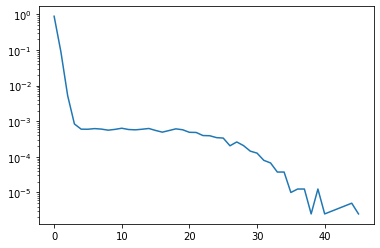

In [4]:
stats = env.get_stats()
n_photons = stats['n_photons_tot_0']


unique, counts = np.unique(n_photons, return_counts=True)
plt.semilogy(unique, counts/n_rep)